In [1]:
import numpy as np 
import pandas as pd 
import os
import json

from tqdm import tqdm

# FUNSD Dataset

## File Structure

In [2]:
stopper = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        stopper += 1
        if stopper>10:
            break

/kaggle/input/funsdform-understanding-noisy-scanned-documents/dataset/training_data/annotations/0060036622.json
/kaggle/input/funsdform-understanding-noisy-scanned-documents/dataset/training_data/annotations/12052385.json
/kaggle/input/funsdform-understanding-noisy-scanned-documents/dataset/training_data/annotations/12825369.json
/kaggle/input/funsdform-understanding-noisy-scanned-documents/dataset/training_data/annotations/71563825.json
/kaggle/input/funsdform-understanding-noisy-scanned-documents/dataset/training_data/annotations/0011906503.json
/kaggle/input/funsdform-understanding-noisy-scanned-documents/dataset/training_data/annotations/91914407.json
/kaggle/input/funsdform-understanding-noisy-scanned-documents/dataset/training_data/annotations/0012529284.json
/kaggle/input/funsdform-understanding-noisy-scanned-documents/dataset/training_data/annotations/91581919.json
/kaggle/input/funsdform-understanding-noisy-scanned-documents/dataset/training_data/annotations/00837285.json
/kag

## Annotation

In [3]:
with open('/kaggle/input/funsdform-understanding-noisy-scanned-documents/dataset/training_data/annotations/0060036622.json', 'r') as f:
    data = json.load(f)

full_text = []
for block in data['form']:
    full_text.append(block['text'])

full_text_str = " ".join([x for x in full_text])
print(full_text_str)

TO: From: Contribution Requested by 1976 ☑ Message  Mr. G. J. Schramm Mr. W. P. Myhan Mr. F. X. Whelan Mr. R. H. Stinnette Mr. J. B. McCarthy E. E. Curtin Request for contribution or membership to be considered by contributions Committee at next meeting ☐ Membership Harvard Medical School and Dr. Gary Huber Boston, Massachusetts Letter 8/ 1/ 76 For American Brands, Inc. Recent actions regarding above solicitor  1976 $ 40, 921. 30 by A. B., Inc. 1975 84, 309. 94 A. B., Inc. 1974 92, 131. 29 A. B., Inc. 1973 91, 630. 53 A. B., Inc. Remarks - Payment - For confirmation by the Committee. Check for $ 43, 910. 30 representing the ninth semi- annual installment to the Harvard Project transmitted August 1976. Decision of Committee on Present Request - Pay - $ Declined - Send letter YES NO Consideration deferred until Committee meeting  8/ 26


In [4]:
def move_up(lst, index):
    """Moves the element at the given index one position up in the list."""
    if index > 0:
        lst[index], lst[index - 1] = lst[index - 1], lst[index]

def sort_postpro(my_list):
    for i, x in enumerate(my_list):
        current_x_min = x['bbox'][0]
        previous_x_min = my_list[i-1]['bbox'][0]
        if previous_x_min<current_x_min:
            pass # this is the way it should be, reading right to left
        else:
            if previous_x_min-current_x_min>200:
                pass # probably so large because we've moved to a new line
            else: # otherwise, move the item up in the list
                move_up(my_list,i)
    return my_list


def extract_text_rtl(json_file_path):
    # Load the JSON file
    with open(json_file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Extract text and bounding boxes
    text_elements = []
    for block in data['form']:
        text = block.get('text', '')
        bbox = block.get('box', [])  # [x_min, y_min, x_max, y_max]
        if bbox and text:
            text_elements.append({'text': text, 'bbox': bbox})
    
    text_elements.sort(key=lambda x: (x['bbox'][1], -x['bbox'][2]))

    rtl_text = ' '.join([elem['text'] for elem in text_elements])
    
    return rtl_text

json_file_path = '/kaggle/input/funsdform-understanding-noisy-scanned-documents/dataset/training_data/annotations/0060036622.json'
rtl_text = extract_text_rtl(json_file_path)   
print(rtl_text)

Mr. W. P. Myhan Mr. G. J. Schramm TO: Mr. F. X. Whelan Mr. R. H. Stinnette Mr. J. B. McCarthy E. E. Curtin From: Request for contribution or membership to be considered by contributions Committee at next meeting ☑ ☐ Membership Contribution Harvard Medical School and Dr. Gary Huber Boston, Massachusetts by Requested Letter 8/ 1/ 76 Message For American Brands, Inc. Recent actions regarding above solicitor  1976 $ 40, 921. 30 by A. B., Inc. Payment - 1975 84, 309. 94 A. B., Inc. 1974 92, 131. 29 A. B., Inc. 1973 91, 630. 53 A. B., Inc. Remarks - For confirmation by the Committee. Check for $ 43, 910. 30 representing the ninth semi- annual installment to the Harvard Project transmitted August 1976. Decision of Committee on Present Request - Pay - $ Declined - Send letter YES NO 8/ 26 Consideration deferred until 1976 Committee meeting 


## Image

In [5]:
image_path = "/kaggle/input/funsdform-understanding-noisy-scanned-documents/dataset/training_data/images/0060036622.png"

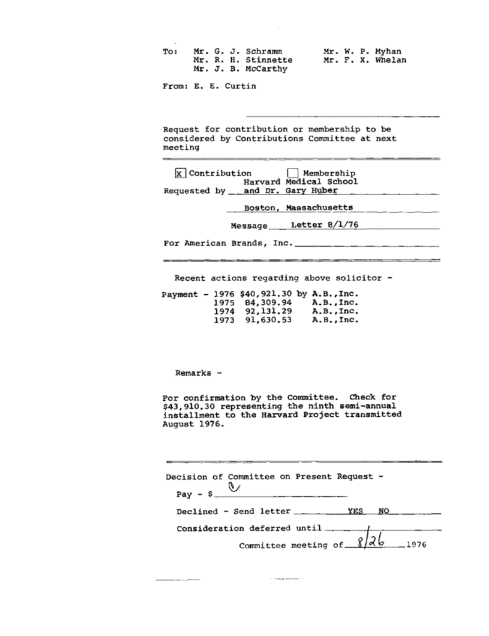

In [6]:
import cv2
import matplotlib.pyplot as plt

# Load the image using OpenCV
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display

# Set a larger figure size
plt.figure(figsize=(10, 8))  # Adjust width and height as needed
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


# Metrics

## Rouge

In [7]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=41d46ef451bea98c2408f8dc70cf46e66c75a03be201cac0b280dd2dc6c1b4ab
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


# Models

## Extractous - *(It uses Tesseract-OCR in backend) [Reference](https://github.com/yobix-ai/extractous)*

In [13]:
from PIL import Image
import pytesseract

In [9]:
# Simple image to string
print(pytesseract.image_to_string(Image.open(image_path)))

To: Mr. G. J. Schramm Mr. W. P. Myhan
Mr. R. H. Stinnette Mr. F, X, Whelan
Mr. J. B. McCarthy

From: BE. E, Curtin

Request for contribution or membership to be
considered by Contributions Committee at next
meeting

 

 

 

el contribution (Membership
Harvard Medical School
Requested by and Dr. Gary Huber

 

 

Boston, Massachusetts 0

Message__ Letter @/1/76

For American Brands, Inc.

   

 

 

Recent actions regarding above solicitor -

Payment - 1976 $40,921.30 by A.B.,Inc.
1975 84,309.94 ALB. , Inc.
1974 92,131.29
1973 91,630.53

 

Remarks ~

For confirmation by the Committee. Check for
$43,910.30 representing the ninth semi-annual
installment to the Harvard Project transmitted
August 1976.

 

 

Decision of Committee on Present Request -
Pay - §
Declined - Send letter YES NO

Consideration deferred until
comnitese meeting of 2/26 i076

   



## doctr

In [ ]:
!pip install "python-doctr[torch,viz,html,contrib]"

In [ ]:
!pip install onnx==1.16.1

In [ ]:
!pip install tf2onnx

In [5]:
from onnx.onnx_cpp2py_export import ONNX_ML
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

In [6]:
model = ocr_predictor('fast_base','crnn_mobilenet_v3_small', pretrained=True)

  0%|          | 0/65814772 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/doctr/models/utils/pytorch.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(archive_path, map_location="c

  0%|          | 0/8420979 [00:00<?, ?it/s]

In [15]:
doc = DocumentFile.from_images(image_path)
result = model(doc)
string_result = result.render()
print(string_result)

## Surya OCR

In [ ]:
pip install surya-ocr

In [ ]:
from PIL import Image
from surya.recognition import RecognitionPredictor
from surya.detection import DetectionPredictor

image = Image.open(image_path)
langs = ["en"] # Replace with your languages or pass None (recommended to use None)
recognition_predictor = RecognitionPredictor()
detection_predictor = DetectionPredictor()

predictions = recognition_predictor([image], [langs], detection_predictor)

In [18]:
str = ""
for i in range(0,len(predictions[0].text_lines)):
    str+=predictions[0].text_lines[i].text+" "
print(str)    

Mr. W. P. Myhan TO : Mr. G. J. Schramm Mr. R. H. Stinnette Mr. F. X. Whelan Mr. J. B. McCarthy From: E. E. Curtin Request for contribution or membership to be considered by Contributions Committee at next meeting and and the see x | Contribution | Membership Harvard Medical School Requested by ___ and Dr. Gary Huber __ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ Boston, Massachusetts Message _____ Letter 8/1/76 For American Brands, Inc. ___________________________________________________________________________________________________________________________________________________ International program program and ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------- Recent actions regarding above solicitor - Payment - 1976 $40,921.30 by A.B.,Inc. 84,309.94 A.B. Inc. 1975 1974 91,630.53 A.B. Inc. 1973 Remarks - Check for For confir

## Rapid OCR

In [ ]:
pip install rapidocr_onnxruntime

In [ ]:
from rapidocr_onnxruntime import RapidOCR

engine = RapidOCR()

img_path = image_path
result, elapse = engine(img_path)

In [21]:
str = ""
for i in range(0, len(result)):
    str+= result[i][1]+" "
print(str)    

To: Mr.G.J. Schramm Mr.W.P.Myhan Mr.R.H. Stinnette Mr.F.X.Whelan Mr.J.B.McCarthy From: E.E.Curtin Request for contribution or membership to be considered by Contributions Committee at next meeting X Contribution Membership Harvard Medical School Requested by and Dr.Gary Huber Boston,Massachugetts Message, Letter8/1/76 For American Brands,Inc. Recent actions regarding above solicitor Payment-1976 $40,921.30 by A.B.,Inc. 1975 84,309.94 A.B.,Inc. 1974 92,131.29 A.B.,Inc. 1973 91,630.53 A.B.,InC. Remarks For confirmationby the Committee. Check for $43,910.30 representing the ninth semi-annual installment to the Harvard Projecttransmitted August 1976. Decision of Committee on Present Request - Pay-$ Declined -Send letter YES NO Consideration deferred until Committee meeting of. 1976 


## Paddle OCR

In [ ]:
pip install paddleocr paddlepaddle

In [ ]:
def paddleocr_processing(image_path):
    result = ocr.ocr(image_path, cls=True)
    str = ""
    # Display results
    for line in result:
        for word_info in line:
            text, confidence = word_info[1]
            str+= text+" "
        str+="\n" 
    return str  

## Marker

In [ ]:
pip install marker-pdf

In [ ]:
!marker /content/drive/MyDrive/OCR_datasets/STROIE/test_data/img --workers 3 --output_dir /content/drive/MyDrive/OCR_datasets/marker_stroie

## Unstructured IO

In [ ]:
pip install "unstructured[image]"

In [ ]:
from unstructured.partition.auto import partition

def unstructured(image_path):
    elements = partition(filename=image_path)
    return "".join([str(el) for el in elements])

# Dataframe for Predictions (All Models) and Reference (Dataset)

In [11]:
def doctr_processing(image_path):
    doc = DocumentFile.from_images(image_path)
    result = model(doc)
    string_result = result.render()
    return string_result

def pytes_processing(image_path):
    return pytesseract.image_to_string(Image.open(image_path))

def surya_processing(image_path):
    image = Image.open(image_path)
    langs = ["en"]
    predictions = recognition_predictor([image], [langs], detection_predictor)
    str = ""
    for i in range(0,len(predictions[0].text_lines)):
        str+=predictions[0].text_lines[i].text+" "
    return str

def rapidocr_processing(image_path):
    result, elapse = engine(image_path)
    str = ""
    for i in range(0, len(result)):
        str+= result[i][1]+" "
    return str

def unstructured(image_path):
    elements = partition(filename=image_path)
    return "".join([str(el) for el in elements])

def paddleocr_processing(image_path):
    result = ocr.ocr(image_path, cls=True)
    str = ""
    # Display results
    for line in result:
        for word_info in line:
            text, confidence = word_info[1]
            str+= text+" "
        str+="\n" 
    return str  

In [ ]:
filenames = []
image_txt = []
pytes_txt = []
doctr_txt = []
surya_txt = []
rapidocr_txt = []
google_vision_api_txt = []
paddleocr_txt = []
azure_intelligence_ai_txt = []
amazon_textract_txt = []
marker_txt = []
unstructured_io_txt = []

images_path = "/kaggle/input/funsdform-understanding-noisy-scanned-documents/dataset/training_data/images"
annota_path = "/kaggle/input/funsdform-understanding-noisy-scanned-documents/dataset/training_data/annotations/"

#Surya initializing
recognition_predictor = RecognitionPredictor()
detection_predictor = DetectionPredictor()

for filename in tqdm(os.listdir(images_path)):
    if filename.endswith(".jpg"): 
        fname_noex = filename[:-4]
        filenames.append(fname_noex)
        json_file_path = annota_path + fname_noex + '.json'
        image_txt.append(extract_text_rtl(json_file_path)) 
        image_path = images_path + filename
        doctr_txt.append(doctr_processing(image_path))
        pytes_txt.append(pytes_processing(image_path))
        surya_txt.append(surya_processing(image_path))
        rapidocr_txt.append(rapidocr_processing(image_path))
        google_vision_api_txt = .append(google_vision_processing(image_path))
        paddleocr_txt = .append(paddleocr_processing(image_path))
        azure_intelligence_ai_txt = .append(azure_intelligence_processing(image_path))
        amazon_textract_txt = .append(amazon_textract_processing(image_path))
        unstructured_io_txt = .append(unstructured_processing(image_path))
    else:
        continue

# print("final filenames len: ", len(filenames))
# print("final filenames sample: ", filenames[:10])
# print("final image_txt len: ", len(image_txt))
# print("final image_txt sample: ", image_txt[0])

In [15]:
df = pd.DataFrame()
df['filename'] = filenames
df['doctr_txt'] = doctr_txt 
df['pytes_txt'] = pytes_txt
df['surya_txt'] = surya_txt
df['rapidocr_txt'] = rapidocr_txt
df['google_vision_api_txt'] = google_vision_api_txt
df['paddleocr_txt'] = paddleocr_txt
df['azure_intelligence_ai_txt'] = azure_intelligence_ai_txt
df['amazon_textract_txt'] = amazon_textract_txt
df['marker_txt'] = marker_txt
df['unstructured_io_txt'] = unstructured_io_txt

df.head()

,filename,doctr_txt,pytes_txt,surya_txt,rapidocr_txt
0,X51005719889,,"\n\nHENG KEE DELIGHTS BAK KUT TEH.\nNO31, JAL...","HENG KEE DELIGHTS BAK KUT TEH. NO31, JAIAN 3/6...","HENG KEE DEIIGHTS BAK KUT TEH. NO31,JALAN 3/62..."
1,X51005447859,,\n\nPASARAYA BORONG PINTAR\n\nSDN BHD\n\nBR N...,PASARAYA BORONG PINTAR SDN BHD BR No : (124525...,PASARAYA BORONGPINTAR SDN BHD BRNo.:（124525-H)...
2,X51006619863,,\n\n \n\n99 SPEED MART S/B (519S37-X)\nLOT ...,"99 SPEED MART 5/8 (519537-X) LOT P.T. 33198, B...","99 SPEED MART S/B (519537-X) LOT P.T.33198,BAT..."
3,X51006619784,,,E LINK SECURITY & OA TRADING @02382060-M) Lot...,BIZ LNK SECURITY &OATRADING(002382060-M) Lot T...
4,X51006733495,,| 99 SPEED MART 5/B (519537-X)\nLOT P.T. 33198...,99 SPEED MART S/B (519537-X) LOT P.T. 33198. B...,"99 SPEED MART S/B (519537-X) LOT P.T.33198,BAT..."


In [16]:
import pandas as pd
dataset = "STROIE" # or FUNSD
df.to_csv(f'/kaggle/working/result_{dataset}_ocr.csv', index=False)  # Set index=False to exclude the index column

print("CSV file saved successfully!")

CSV file saved successfully!


# Do similar process for STROIE dataset and change directories

# And save the txt file for Result Calculation in the other notebook